# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [867]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


In [868]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [869]:
df.index

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='week', length=106, freq=None)

In [870]:
df.isnull().sum()

sales    0
dtype: int64

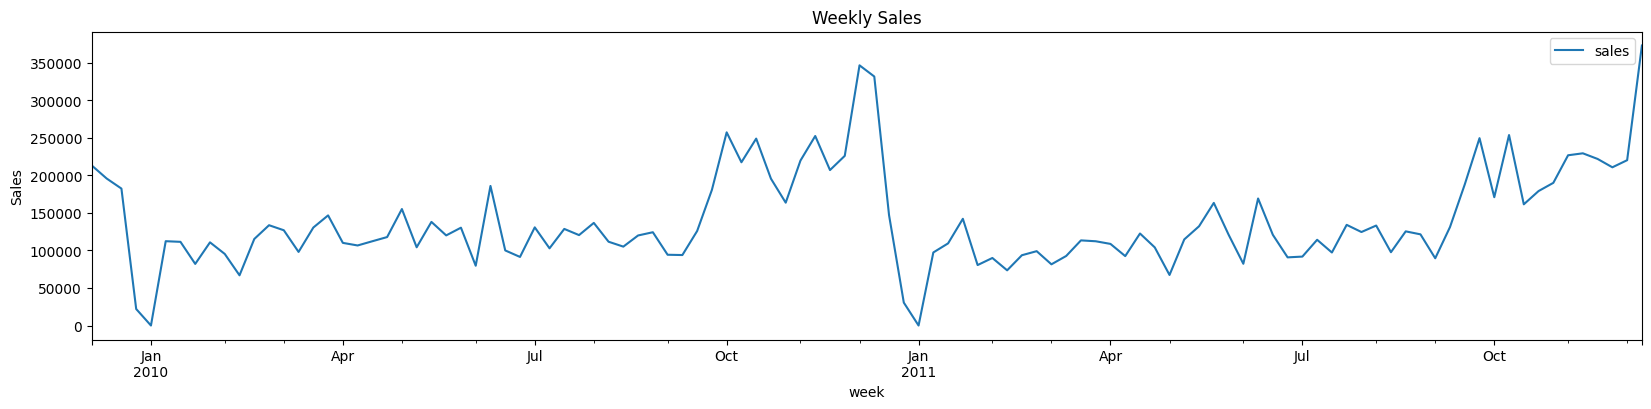

In [871]:
df.plot(figsize=(20,4))
plt.title('Weekly Sales')
plt.ylabel('Sales')
plt.show()

## Missing data

Check if there are missing values in the time series.

In [872]:
df.query(' sales.isnull() ')

,sales
week,


In [873]:
df.query(' sales == 0 ')

,sales
week,
2010-01-03,0.0
2011-01-02,0.0


## Missing timestamps

Check if there are missing timestamps in the index.

In [874]:
print(df.shape)
print(df.asfreq('W').shape)

(106, 1)
(106, 1)


In [875]:
df_2 = df.asfreq('W')

df_data = (
    pd.merge(df_2,
             df,
             how='outer',
             left_index=True,
             right_index=True,
             suffixes = ['_2', '_1'])
)

#df_data = 
(
    df_data
        .assign(filter = df_data['sales_2'] - df_data['sales_1'])
        .query(' filter != 0 ')
)


,sales_2,sales_1,filter
week,,,


In [876]:
df_data = (
    df_data
        .drop(columns=['sales_1'])
        .rename(columns={'sales_2':'sales'})
)

df_data

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
...,...
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76


## Seasonality

Does the time series show any obvious seasonal pattern?

In [877]:
df_data = (
    df_data
        .assign(work_week = df_data.index.isocalendar().week,
                month = df_data.index.month,
                year = df_data.index.year)
)

df_data

,sales,work_week,month,year
week,,,,
2009-12-06,213000.35,49,12,2009
2009-12-13,195810.04,50,12,2009
2009-12-20,182396.74,51,12,2009
2009-12-27,22007.77,52,12,2009
2010-01-03,0.00,53,1,2010
...,...,...,...,...
2011-11-13,229378.01,45,11,2011
2011-11-20,221870.29,46,11,2011
2011-11-27,210741.76,47,11,2011


In [878]:
df_data_wk = (
    df_data
        .drop(columns=['month'])
        .reset_index(drop=True)
        .sort_values(by=['work_week', 'work_week'], ascending=[True, True])
        .reset_index(drop=True)
        .pivot_table(index='work_week', columns='year', values='sales', aggfunc='sum')
)

df_data_month = (
    df_data
        .drop(columns=['work_week'])
        .reset_index(drop=True)
        .sort_values(by=['month', 'year'], ascending=[True, True])
        .reset_index(drop=True)
        .pivot_table(index='month', columns='year', values='sales', aggfunc='sum')
)

#df_data_wk.head()
#df_data_month.head()

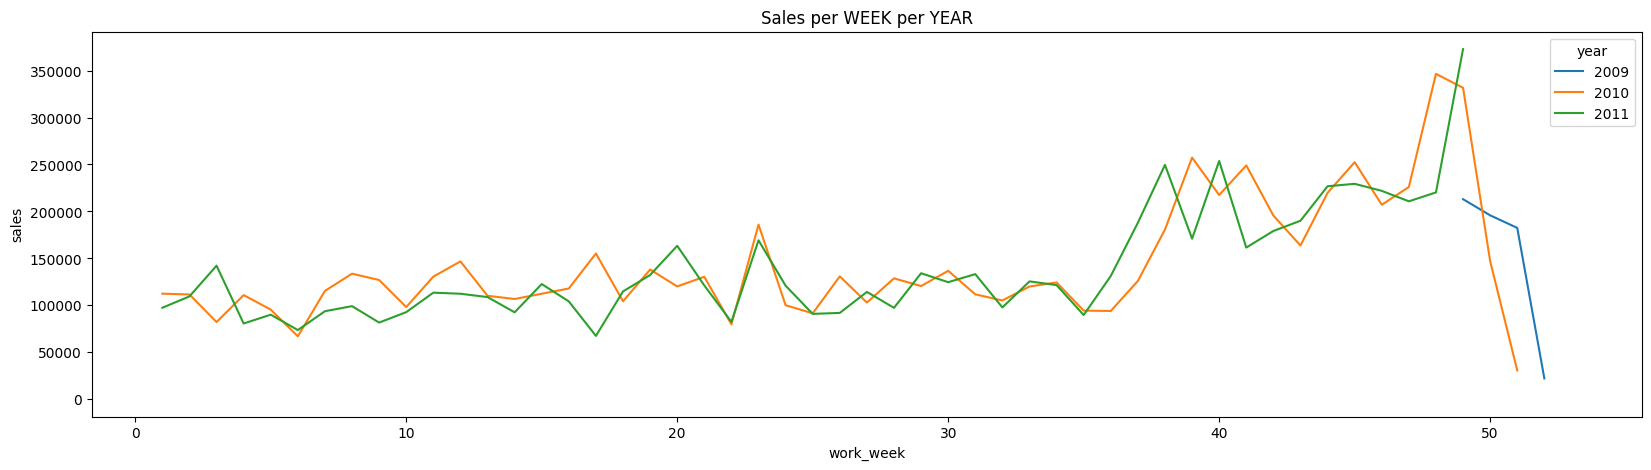

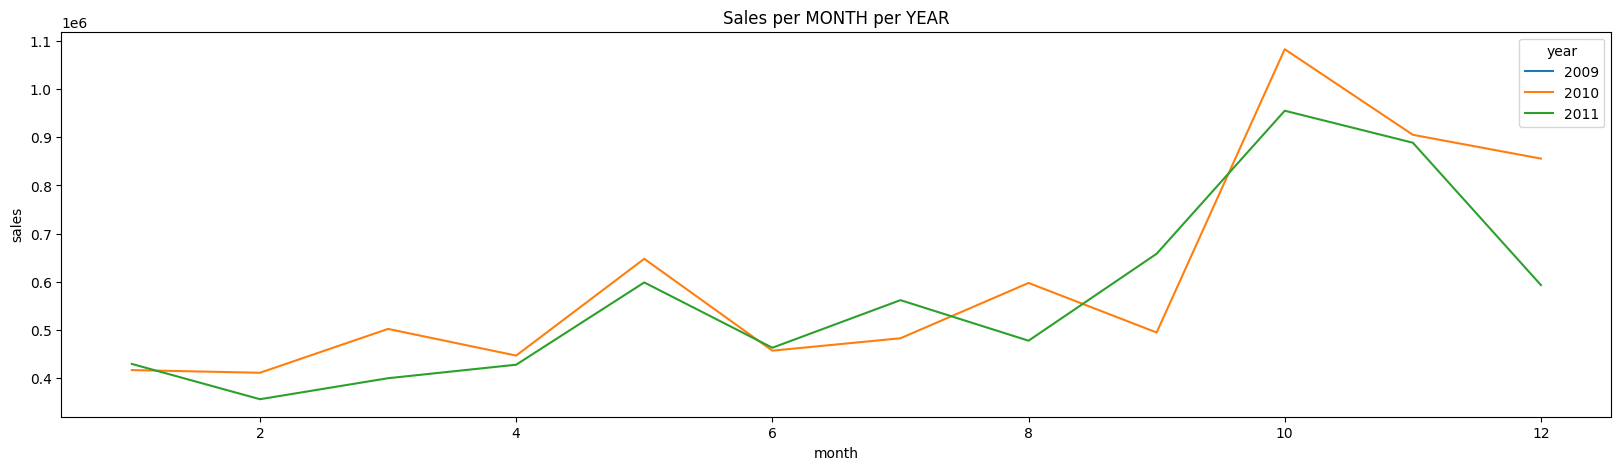

In [879]:
df_data_wk.plot(figsize=[20, 5])
plt.title('Sales per WEEK per YEAR')
plt.ylabel('sales')

df_data_month.plot(figsize=[20, 5])
plt.title('Sales per MONTH per YEAR')
plt.ylabel('sales')
plt.show()

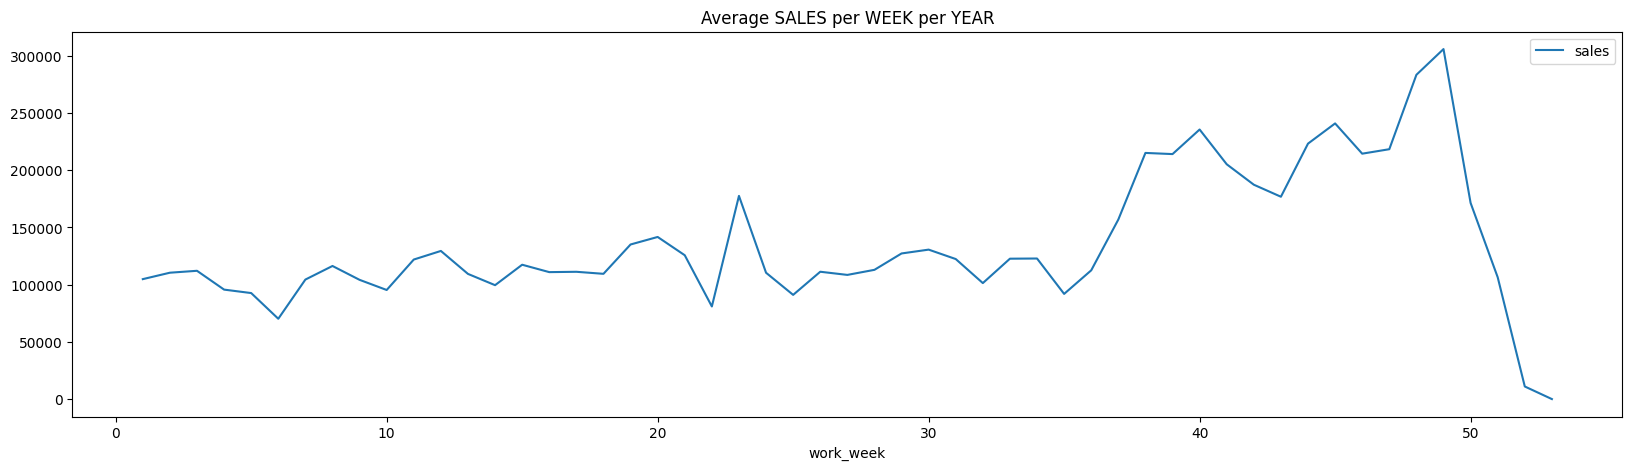

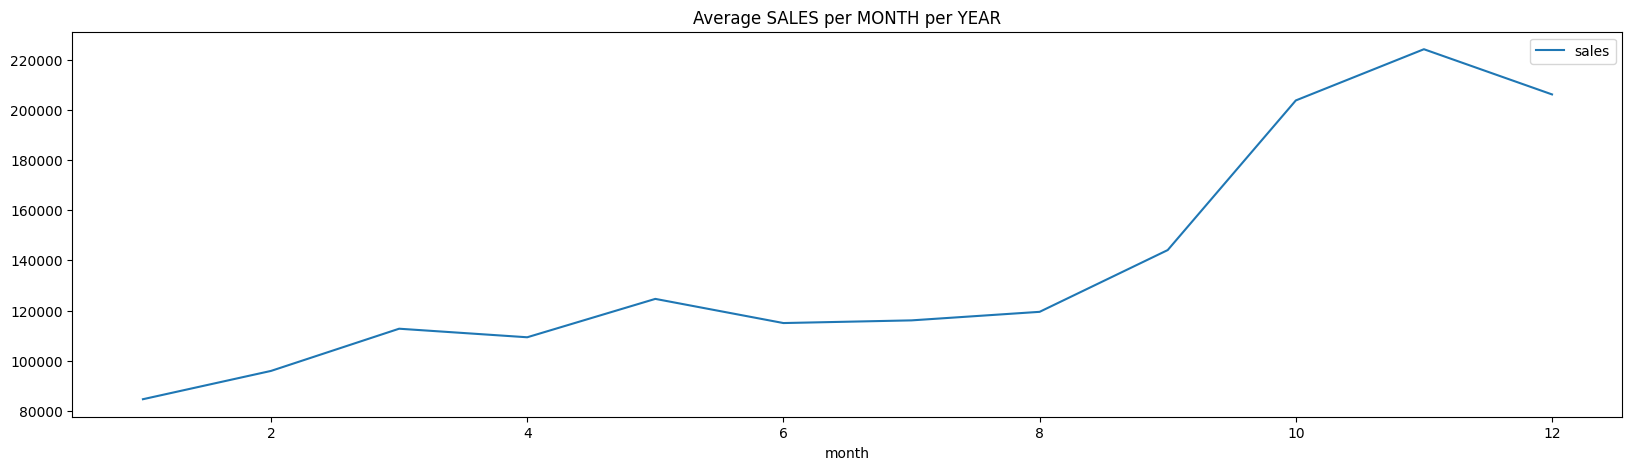

In [880]:
# AVERAGE SALES per WEEK 
(df_data.pivot_table(index='work_week',
                     values='sales',
                     aggfunc=np.mean)
        .plot(figsize=[20, 5]))
plt.title('Average SALES per WEEK per YEAR')

# AVERAGE SALES per MONTH
(df_data.pivot_table(index='month',
                     values='sales',
                     aggfunc=np.mean)
        .plot(figsize=[20, 5]))
plt.title('Average SALES per MONTH per YEAR')

plt.show()

Demand increases from month of August and peaks every December, then drop probably to holiday season.

# Feature engineering

Now, let's begin to tabularize the data.

In [881]:
df_data = (
        df_data
                .rename(columns={'work_week':'wk',
                                  'month':'mth'})
                .drop(columns=['year'])
)

df_data.head()

,sales,wk,mth
week,,,
2009-12-06,213000.35,49,12
2009-12-13,195810.04,50,12
2009-12-20,182396.74,51,12
2009-12-27,22007.77,52,12
2010-01-03,0.00,53,1


In [882]:

df_data = (
   df_data
        #TIME RELATED FEATURES ALREADY DONE

        #LAG FEATURES
        .assign(sales_lag_1 = df_data['sales'].shift(1),
                sales_lag_2 = df_data['sales'].shift(2),
                #sales_lag_3 = df_data['sales'].shift(3),
                
                wk_lag_1 = df_data['wk'].shift(1),
                wk_lag_2 = df_data['wk'].shift(2),
                #wk_lag_3 = df_data['wk'].shift(3),
                
                mth_lag_1 = df_data['mth'].shift(1),
                mth_lag_2 = df_data['mth'].shift(2),
                #mth_lag_3 = df_data['mth'].shift(3)
                )
        
        #LEAD FEATURES
        .assign(sales_lead_1 = df_data['sales'].shift(-1),
                #sales_lead_2 = df_data['sales'].shift(-2),
                
                wk_lead_1 = df_data['wk'].shift(-1),
                #wk_lead_2 = df_data['wk'].shift(-2),
                
                mth_lead_1 = df_data['mth'].shift(-1),
                #mth_lead_2 = df_data['mth'].shift(-2)
                )
        
        #WINDOW LAG FEATURES
        .assign(sales_MIN_2d_lag = df_data['sales'].rolling(window=2).min(),
                sales_MAX_2d_lag = df_data['sales'].rolling(window=2).max(),
                sales_AVE_2d_lag = df_data['sales'].rolling(window=2).mean(),
                sales_STDV_2d_lag = df_data['sales'].rolling(window=2).std(),
                
                #sales_MIN_3d_lag = df_data['sales'].rolling(window=3).min(),
                #sales_MAX_3d_lag = df_data['sales'].rolling(window=3).max(),
                #sales_AVE_3d_lag = df_data['sales'].rolling(window=3).mean(),
                #sales_STDV_3d_lag = df_data['sales'].rolling(window=3).std()
                )
)

df_data

,sales,wk,mth,sales_lag_1,sales_lag_2,wk_lag_1,wk_lag_2,mth_lag_1,mth_lag_2,sales_lead_1,wk_lead_1,mth_lead_1,sales_MIN_2d_lag,sales_MAX_2d_lag,sales_AVE_2d_lag,sales_STDV_2d_lag
week,,,,,,,,,,,,,,,,
2009-12-06,213000.35,49,12,NaN,NaN,<NA>,<NA>,NaN,NaN,195810.04,50,12.0,NaN,NaN,NaN,NaN
2009-12-13,195810.04,50,12,213000.35,NaN,49,<NA>,12.0,NaN,182396.74,51,12.0,195810.04,213000.35,204405.195,12155.384772
2009-12-20,182396.74,51,12,195810.04,213000.35,50,49,12.0,12.0,22007.77,52,12.0,182396.74,195810.04,189103.390,9484.635388
2009-12-27,22007.77,52,12,182396.74,195810.04,51,50,12.0,12.0,0.00,53,1.0,22007.77,182396.74,102202.255,113412.128315
2010-01-03,0.00,53,1,22007.77,182396.74,52,51,12.0,12.0,112318.85,1,1.0,0.00,22007.77,11003.885,15561.843406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,45,11,226770.53,190034.20,44,43,11.0,10.0,221870.29,46,11.0,226770.53,229378.01,228074.270,1843.766790
2011-11-20,221870.29,46,11,229378.01,226770.53,45,44,11.0,11.0,210741.76,47,11.0,221870.29,229378.01,225624.150,5308.759723
2011-11-27,210741.76,47,11,221870.29,229378.01,46,45,11.0,11.0,220213.99,48,12.0,210741.76,221870.29,216306.025,7869.059028


In [883]:
#CYCLICAL FEAETURES

cyclical = CyclicalFeatures(
    variables=["wk", "mth"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df_data = cyclical.fit_transform(df_data)

df_data

,sales,wk,mth,sales_lag_1,sales_lag_2,wk_lag_1,wk_lag_2,mth_lag_1,mth_lag_2,sales_lead_1,wk_lead_1,mth_lead_1,sales_MIN_2d_lag,sales_MAX_2d_lag,sales_AVE_2d_lag,sales_STDV_2d_lag,wk_sin,wk_cos,mth_sin,mth_cos
week,,,,,,,,,,,,,,,,,,,,
2009-12-06,213000.35,49,12,NaN,NaN,<NA>,<NA>,NaN,NaN,195810.04,50,12.0,NaN,NaN,NaN,NaN,-0.456629,0.889657,-2.449294e-16,1.000000
2009-12-13,195810.04,50,12,213000.35,NaN,49,<NA>,12.0,NaN,182396.74,51,12.0,195810.04,213000.35,204405.195,12155.384772,-0.348202,0.93742,-2.449294e-16,1.000000
2009-12-20,182396.74,51,12,195810.04,213000.35,50,49,12.0,12.0,22007.77,52,12.0,182396.74,195810.04,189103.390,9484.635388,-0.234886,0.972023,-2.449294e-16,1.000000
2009-12-27,22007.77,52,12,182396.74,195810.04,51,50,12.0,12.0,0.00,53,1.0,22007.77,182396.74,102202.255,113412.128315,-0.118273,0.992981,-2.449294e-16,1.000000
2010-01-03,0.00,53,1,22007.77,182396.74,52,51,12.0,12.0,112318.85,1,1.0,0.00,22007.77,11003.885,15561.843406,-0.0,1.0,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,45,11,226770.53,190034.20,44,43,11.0,10.0,221870.29,46,11.0,226770.53,229378.01,228074.270,1843.766790,-0.812487,0.582979,-5.000000e-01,0.866025
2011-11-20,221870.29,46,11,229378.01,226770.53,45,44,11.0,11.0,210741.76,47,11.0,221870.29,229378.01,225624.150,5308.759723,-0.737833,0.674983,-5.000000e-01,0.866025
2011-11-27,210741.76,47,11,221870.29,229378.01,46,45,11.0,11.0,220213.99,48,12.0,210741.76,221870.29,216306.025,7869.059028,-0.652822,0.757511,-5.000000e-01,0.866025


In [884]:
df_data.isnull().sum() / len(df_data)

sales                0.000000
wk                   0.000000
mth                  0.000000
sales_lag_1          0.009434
sales_lag_2          0.018868
wk_lag_1             0.009434
wk_lag_2             0.018868
mth_lag_1            0.009434
mth_lag_2            0.018868
sales_lead_1         0.009434
wk_lead_1            0.009434
mth_lead_1           0.009434
sales_MIN_2d_lag     0.009434
sales_MAX_2d_lag     0.009434
sales_AVE_2d_lag     0.009434
sales_STDV_2d_lag    0.009434
wk_sin               0.000000
wk_cos               0.000000
mth_sin              0.000000
mth_cos              0.000000
dtype: float64

In [885]:
print("df_data size before")
print(df_data.shape)

df_data.dropna(inplace=True)

print("df_data size after")
print(df_data.shape)

df_data size before
(106, 20)
df_data size after
(103, 20)


In [886]:
df_data

,sales,wk,mth,sales_lag_1,sales_lag_2,wk_lag_1,wk_lag_2,mth_lag_1,mth_lag_2,sales_lead_1,wk_lead_1,mth_lead_1,sales_MIN_2d_lag,sales_MAX_2d_lag,sales_AVE_2d_lag,sales_STDV_2d_lag,wk_sin,wk_cos,mth_sin,mth_cos
week,,,,,,,,,,,,,,,,,,,,
2009-12-20,182396.74,51,12,195810.04,213000.35,50,49,12.0,12.0,22007.770,52,12.0,182396.74,195810.04,189103.390,9484.635388,-0.234886,0.972023,-2.449294e-16,1.000000
2009-12-27,22007.77,52,12,182396.74,195810.04,51,50,12.0,12.0,0.000,53,1.0,22007.77,182396.74,102202.255,113412.128315,-0.118273,0.992981,-2.449294e-16,1.000000
2010-01-03,0.00,53,1,22007.77,182396.74,52,51,12.0,12.0,112318.850,1,1.0,0.00,22007.77,11003.885,15561.843406,-0.0,1.0,5.000000e-01,0.866025
2010-01-10,112318.85,1,1,0.00,22007.77,53,52,1.0,12.0,111460.470,2,1.0,0.00,112318.85,56159.425,79421.420490,0.118273,0.992981,5.000000e-01,0.866025
2010-01-17,111460.47,2,1,112318.85,0.00,1,53,1.0,1.0,82065.331,3,1.0,111460.47,112318.85,111889.660,606.966319,0.234886,0.972023,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-06,226770.53,44,11,190034.20,179106.07,43,42,10.0,10.0,229378.010,45,11.0,190034.20,226770.53,208402.365,25976.508059,-0.875735,0.482792,-5.000000e-01,0.866025
2011-11-13,229378.01,45,11,226770.53,190034.20,44,43,11.0,10.0,221870.290,46,11.0,226770.53,229378.01,228074.270,1843.766790,-0.812487,0.582979,-5.000000e-01,0.866025
2011-11-20,221870.29,46,11,229378.01,226770.53,45,44,11.0,11.0,210741.760,47,11.0,221870.29,229378.01,225624.150,5308.759723,-0.737833,0.674983,-5.000000e-01,0.866025


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [887]:
df_data.index.min(), df_data.index.max()

(Timestamp('2009-12-20 00:00:00', freq='W-SUN'),
 Timestamp('2011-12-04 00:00:00', freq='W-SUN'))

In [888]:
X_train = df_data[df_data.index <= "2011-8-21"]
X_test = df_data[df_data.index > "2011-8-21"]

X_train.shape, X_test.shape

((88, 20), (15, 20))

In [889]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [890]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  48544.4476866388
test rmse:  47186.74920481825


# Machine Learning

## RANDOM FOREST

In [891]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [892]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  16695.450093281415
test rmse:  25337.23379346346


## LINEAR REGRESSION

In [893]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [894]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  10.574055863758232
test rmse:  15.795248129658708


Text(0, 0.5, 'Importance')

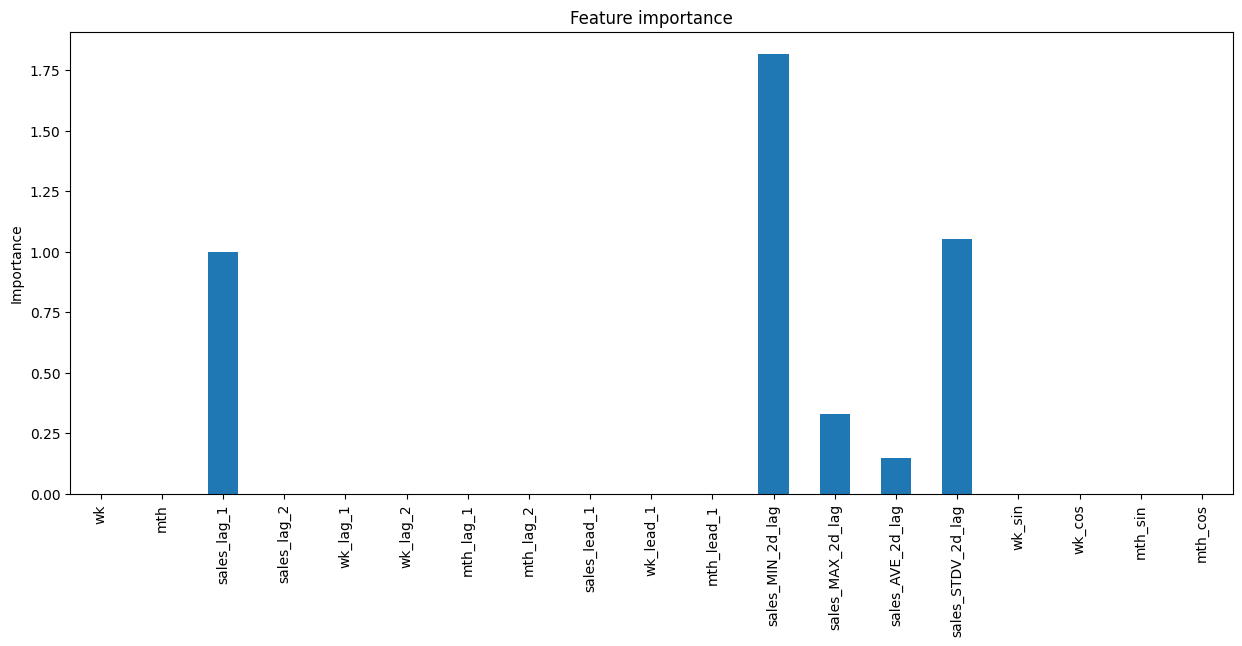

In [895]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

# CONCLUSION

In [896]:
# Performance of random forests
print("RANDOM FOREST train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))
print("RANDOM FOREST test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

print('------------------------------------------------------')

# Performance of linear model
print("LINEAR REGRESSION train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))
print("LINEAR REGRESSION test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

print('')
print(' ** Linear Regression model performs better than Random Forest for this dataset ** ')

RANDOM FOREST train rmse:  16695.450093281415
RANDOM FOREST test rmse:  25337.23379346346
------------------------------------------------------
LINEAR REGRESSION train rmse:  10.574055863758232
LINEAR REGRESSION test rmse:  15.795248129658708

 ** Linear Regression model performs better than Random Forest for this dataset ** 
